In [11]:
import pandas as pd
import numpy as np
from experimental_metrics import *
from single_modal_vector_retrieval import *
from early_fusion import *
from late_fusion import *
from metadata_graph import *
from random_sample import *
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from experimental_metrics import *
from diversity_aware_retrieval import *
%matplotlib inline

In [13]:
ground_truth = np.loadtxt('./predictions/binary_relevancy_matrix_00.csv', delimiter="\t")
infos = pd.read_csv('./dataset/id_information_mmsr.tsv', sep='\t')
tags = pd.read_csv('./dataset/id_tags_dict.tsv', sep='\t')
genres = pd.read_csv('./dataset/id_genres_mmsr.tsv', sep='\t')

song_ids = infos['id'].tolist()
song_id_to_index = {song_id: idx for idx, song_id in enumerate(song_ids)}

In [14]:
to_retrieve = 500
topK = 100

In [15]:
random_sample = all_random(infos, topK=to_retrieve)
late_fusion = np.loadtxt('./predictions/rets_late_fusion_500_matrix.csv', delimiter=",")

Using 4 cores for Random Recommendations.


Processing Random Recommendations: 100%|██████████| 5148/5148 [00:09<00:00, 532.21it/s]


## Extracting Results

In [ ]:
# Shift Method
best_shift_factor = 0

late_fusion_shifted = np.zeros((len(infos), len(infos)))
sorted_indices = np.argsort(late_fusion, axis=1)[:, ::-1][:, best_shift_factor:topK+best_shift_factor]
sorted_values = np.sort(late_fusion, axis=1)[:, ::-1][:, best_shift_factor:topK+best_shift_factor]
np.put_along_axis(late_fusion_shifted, sorted_indices, sorted_values, axis=1)

# p-shift
best_p = 5
best_shift_factor = 28

late_fusion_p_shifted = np.zeros((len(infos), len(infos)))

sorted_indices = np.argsort(late_fusion, axis=1)[:, ::-1]
earlier_half_indices = sorted_indices[:, 0:best_p]
later_half_indices = sorted_indices[:, best_shift_factor+best_p:topK+best_shift_factor]

sorted_values = np.sort(late_fusion, axis=1)[:, ::-1]
earlier_half_values = sorted_values[:, 0:best_p]
later_half_values = sorted_values[:, best_shift_factor+best_p:topK+best_shift_factor]

combined_indices = np.concatenate((earlier_half_indices, later_half_indices), axis=1)
combined_values = np.concatenate((earlier_half_values, later_half_values), axis=1)

np.put_along_axis(late_fusion_p_shifted, combined_indices, combined_values, axis=1)

late_fusion_p_shifted = late_fusion_p_shifted.T

# exponential method
best_lambda = 0.06

late_fusion_exp = np.zeros((len(infos), len(infos)))
for idx, val in enumerate(late_fusion):
    normalized_scores = normalize(val)
    probabilities = softmax_with_temperature(normalized_scores, temperature=best_lambda)
    selected_items = select_items_unique(probabilities, topK=topK)
    late_fusion_exp[idx, selected_items] = val[selected_items]

# Power Exponential Method
best_poower = 4
best_lambda = 0.12

late_fusion_power = np.zeros((len(infos), len(infos)))
for idx, val in enumerate(late_fusion):
    normalized_scores = normalize(val)
    adjusted_scores = adjust_weights(normalized_scores, power=best_poower)
    probabilities = softmax_with_temperature(adjusted_scores, temperature=best_lambda)
    selected_items = select_items_unique(probabilities, topK=topK)
    late_fusion_power[idx, selected_items] = val[selected_items]

# MMR
best_lambda = 0.59
late_fusion_mmr = np.zeros((len(infos), len(infos)))
res_mmr = [get_diverse_recommendations_batch(song, random_sample, k=topK, lambda_diversity=best_lambda)
                                        for song in random_sample]

for idx, res in enumerate(res_mmr):
            late_fusion_mmr[idx, res] = late_fusion[idx, res]

# Export
np.savetxt('./predictions/rets_shifted_100_matrix.csv', late_fusion_shifted, delimiter=",")
np.savetxt('./predictions/rets_p_shifted_100_matrix.csv', late_fusion_p_shifted, delimiter=",")
np.savetxt('./predictions/rets_exp_100_matrix.csv', late_fusion_exp, delimiter=",")
np.savetxt('./predictions/rets_power_100_matrix.csv', late_fusion_power, delimiter=",")
np.savetxt('./predictions/rets_mmr_100_matrix.csv', late_fusion_mmr, delimiter=",")


NameError: name 'late_fusion' is not defined

# Shift Method

So when re-ranking, we just remove the top-results, by shifting over.

We do this for up to to_retrieve - topK results

In [41]:
divs_random = []
ndcg_random = []
divs_late_fusion = []
ndcg_late_fusion = []
for i in tqdm(range(0, 100), total=100):    
    random_sample_shifted = np.zeros((len(infos), len(infos)))
    sorted_indices = np.argsort(random_sample, axis=1)[:, ::-1][:, i:topK+i]
    sorted_values = np.sort(random_sample, axis=1)[:, ::-1][:, i:topK+i]
    np.put_along_axis(random_sample_shifted, sorted_indices, sorted_values, axis=1)
    
    late_fusion_shifted = np.zeros((len(infos), len(infos)))
    sorted_indices = np.argsort(late_fusion, axis=1)[:, ::-1][:, i:topK+i]
    sorted_values = np.sort(late_fusion, axis=1)[:, ::-1][:, i:topK+i]
    np.put_along_axis(late_fusion_shifted, sorted_indices, sorted_values, axis=1)

    random_sample_shifted = random_sample_shifted.T
    late_fusion_shifted = late_fusion_shifted.T
    
    divs_random.append(diversity_at_k(random_sample_shifted, tags, genres, k=topK))
    ndcg_random.append(ndcg_at_k(random_sample_shifted, ground_truth, k=topK))

    divs_late_fusion.append(diversity_at_k(late_fusion_shifted, tags, genres, k=topK))
    ndcg_late_fusion.append(ndcg_at_k(late_fusion_shifted, ground_truth, k=topK))

100%|██████████| 100/100 [16:24<00:00,  9.84s/it]


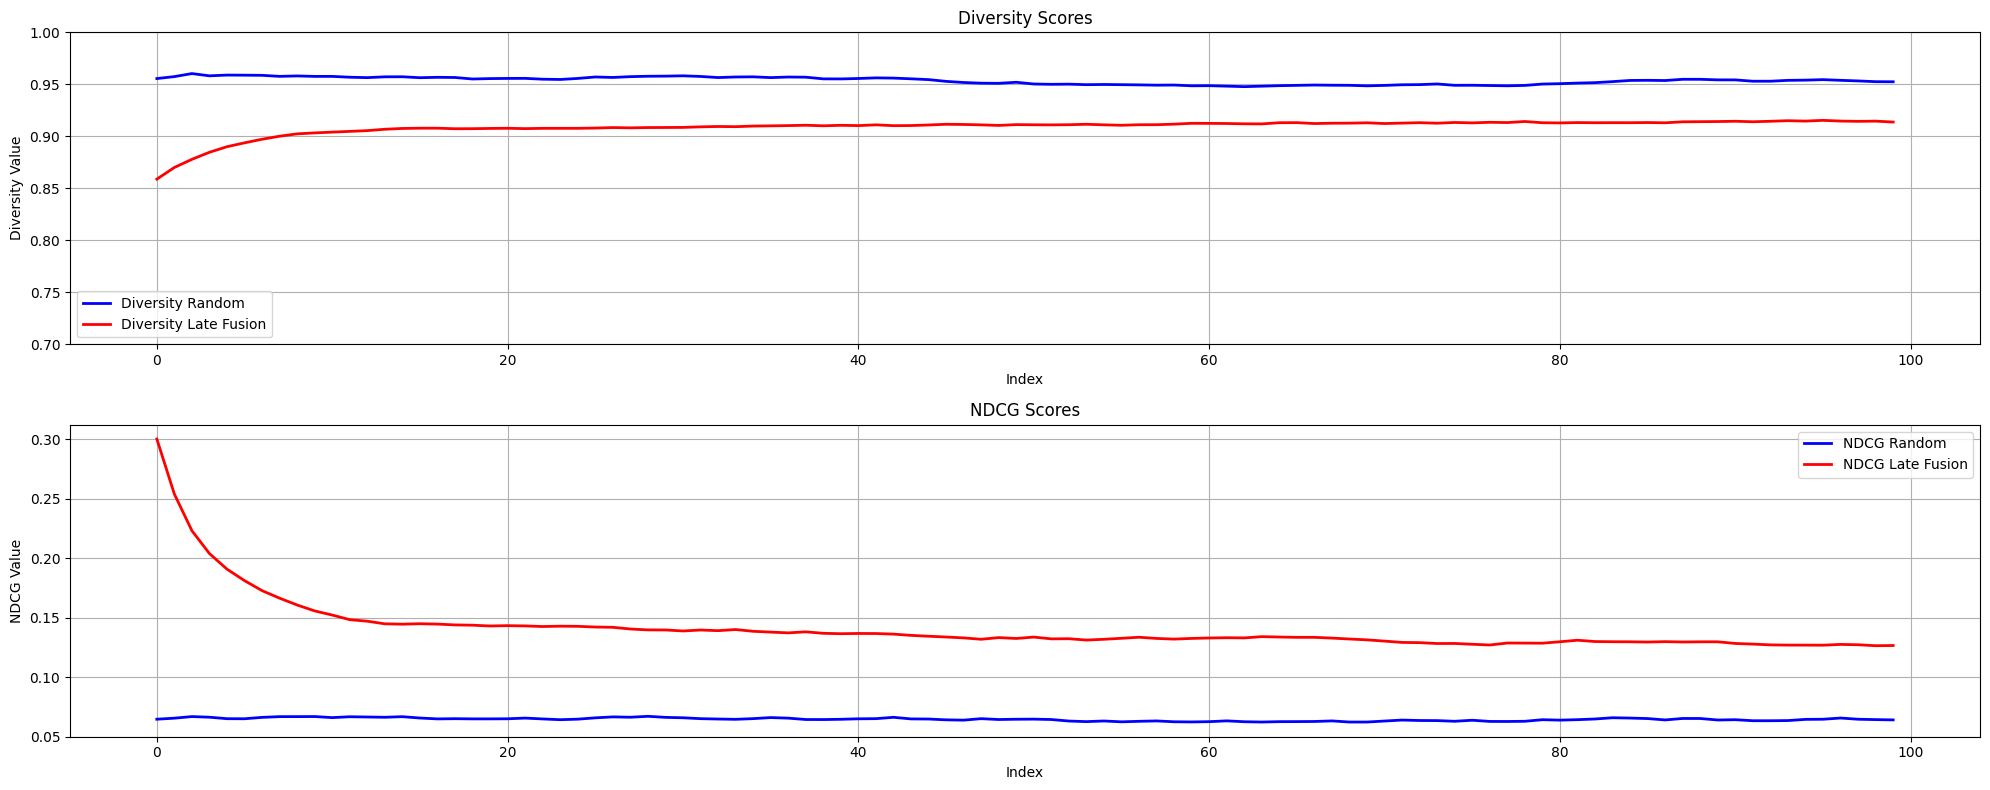

In [ ]:
# Create subplots: 2 rows, 1 column

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))  # figsize adjusts the overall plot size
y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)

# Plot div values on the first subplot (ax1)
ax1.plot(range(len(divs_random)), divs_random, label='Diversity Random', color='blue', linewidth=2)
ax1.plot(range(len(divs_late_fusion)), divs_late_fusion, label='Diversity Late Fusion', color='red', linewidth=2)
ax1.set_xlabel('Index')  # Label for the x-axis
ax1.set_ylabel('Diversity Value')  # Label for the y-axis
ax1.set_title('Diversity Scores')  # Title for the plot
ax1.set_yticks(y_ticks)  # Set y-ticks using the common step size
ax1.legend()  # Show legend
ax1.grid(True)  # Show grid

# Plot ndcg values on the second subplot (ax2)
ax2.plot(range(len(ndcg_random)), ndcg_random, label='NDCG Random', color='blue', linewidth=2)
ax2.plot(range(len(ndcg_late_fusion)), ndcg_late_fusion, label='NDCG Late Fusion', color='red', linewidth=2)
ax2.set_xlabel('Index')  # Label for the x-axis
ax2.set_ylabel('NDCG Value')  # Label for the y-axis
ax2.set_title('NDCG Scores')  # Title for the plot
ax2.set_yticks(y_ticks_2)  # Set y-ticks using the common step size
ax2.legend()  # Show legend
ax2.grid(True)  # Show grid

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

[0.6073854611660904, 0.592715702049358, 0.5831838332631302, 0.578287556199373, 0.5753287722295902, 0.5730405496774802, 0.5711529353310342, 0.569919213496588, 0.5685827149961713, 0.5668536637309706, 0.5656963127463961, 0.5643493892242583, 0.5641611405421807, 0.5639011364761294, 0.5641954035613028, 0.5644960530391121, 0.5643654003500533, 0.5637606267685917, 0.5636855850194818, 0.563507058409418, 0.5637291793565544, 0.5634385374831637, 0.5633591508398353, 0.5635012973809488, 0.5634492963169204, 0.563327681421078, 0.5634766900471191, 0.5626859949954395, 0.5624983716064164, 0.5625084714505695, 0.5621776579919662, 0.5628320019984314, 0.5627783372275549, 0.5631092018086903, 0.5627599379606868, 0.5625674120471994, 0.5624127303214861, 0.5629933747488495, 0.5621431257249158, 0.5622487867135421, 0.5621897959923347, 0.5625564339391979, 0.5619085153406241, 0.5614963659015271, 0.5614687257520554, 0.5615479401831616, 0.5611108100734067, 0.5603836039001663, 0.5607209327828063, 0.5608136867302895, 0.56

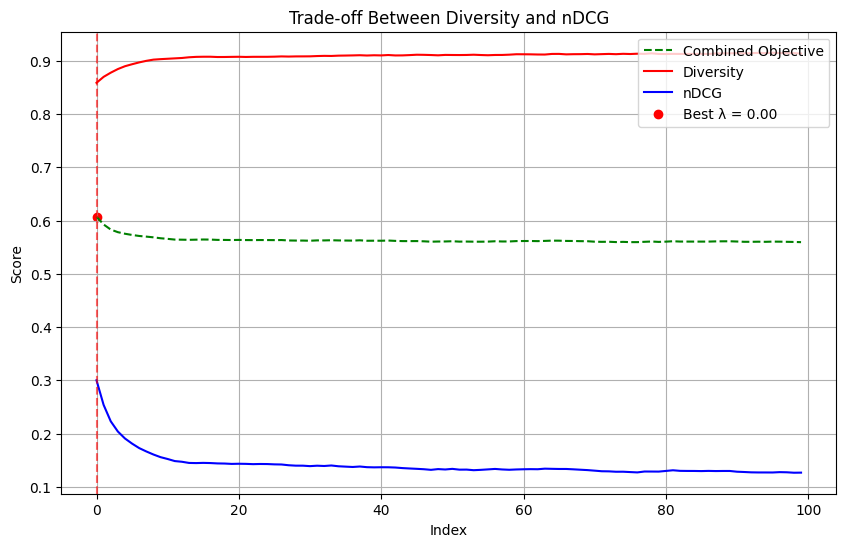

Best Lambda: 0.00
Best Combined Objective: 0.6074
Diversity at Best Lambda: 0.8588
NDCG at Best Lambda: 0.3001


In [ ]:
alpha = 0.55  # Equal weight for diversity and NDCG

# Compute the combined objective
combined_objective = [
    alpha * div + (1 - alpha) * ndcg
    for div, ndcg in zip(divs_late_fusion, ndcg_late_fusion)
]

# Find the best lambda
best_index = np.argmax(combined_objective)
best_lambda = range(len(divs_late_fusion))[best_index]
best_objective = combined_objective[best_index]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Diversity and NDCG

# Plot combined objective
plt.plot(range(len(divs_late_fusion)), combined_objective, label="Combined Objective", linestyle='--', color='green')
plt.plot(range(len(divs_late_fusion)), divs_late_fusion, label="Diversity", color='red')
plt.plot(range(len(divs_late_fusion)), ndcg_late_fusion, label="nDCG", color='blue')

# Mark the best lambda
plt.scatter(best_lambda, best_objective, color='red', label=f"Best λ = {best_lambda:.2f}")
plt.axvline(best_lambda, color='red', linestyle='--', alpha=0.6)

# Labels and legend
plt.title("Trade-off Between Diversity and nDCG")
plt.xlabel("Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Half-Shift 

only shifting half the list so always keeping the top 5 results

In [43]:
shift_numbers = to_retrieve-topK
to_keep = 5

divs_random_half = []
ndcg_random_half = []
divs_late_fusion_half = []
ndcg_late_fusion_half = []
for i in tqdm(range(0, 100), total=100):    
    random_sample_shifted = np.zeros((len(infos), len(infos)))
    sorted_indices = np.argsort(random_sample, axis=1)[:, ::-1]
    earlier_half_indices = sorted_indices[:, 0:to_keep]
    later_half_indices = sorted_indices[:, i+to_keep:topK+i]
    sorted_values = np.sort(random_sample, axis=1)[:, ::-1]
    earlier_half_values = sorted_values[:, 0:to_keep]
    later_half_values = sorted_values[:, i+to_keep:topK+i]
    combined_indices = np.concatenate((earlier_half_indices, later_half_indices), axis=1)
    combined_values = np.concatenate((earlier_half_values, later_half_values), axis=1)
    np.put_along_axis(random_sample_shifted, combined_indices, combined_values, axis=1)
    
    late_fusion_shifted = np.zeros((len(infos), len(infos)))
    sorted_indices = np.argsort(late_fusion, axis=1)[:, ::-1]
    earlier_half_indices = sorted_indices[:, 0:to_keep]
    later_half_indices = sorted_indices[:, i+to_keep:topK+i]
    sorted_values = np.sort(late_fusion, axis=1)[:, ::-1]
    earlier_half_values = sorted_values[:, 0:to_keep]
    later_half_values = sorted_values[:, i+to_keep:topK+i]
    combined_indices = np.concatenate((earlier_half_indices, later_half_indices), axis=1)
    combined_values = np.concatenate((earlier_half_values, later_half_values), axis=1)
    np.put_along_axis(late_fusion_shifted, combined_indices, combined_values, axis=1)
    
    random_sample_shifted = random_sample_shifted.T
    late_fusion_shifted = late_fusion_shifted.T

    divs_random_half.append(diversity_at_k(random_sample_shifted, tags, genres, k=topK))
    ndcg_random_half.append(ndcg_at_k(random_sample_shifted, ground_truth, k=topK))

    divs_late_fusion_half.append(diversity_at_k(late_fusion_shifted, tags, genres, k=topK))
    ndcg_late_fusion_half.append(ndcg_at_k(late_fusion_shifted, ground_truth, k=topK))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [15:10<00:00,  9.10s/it]


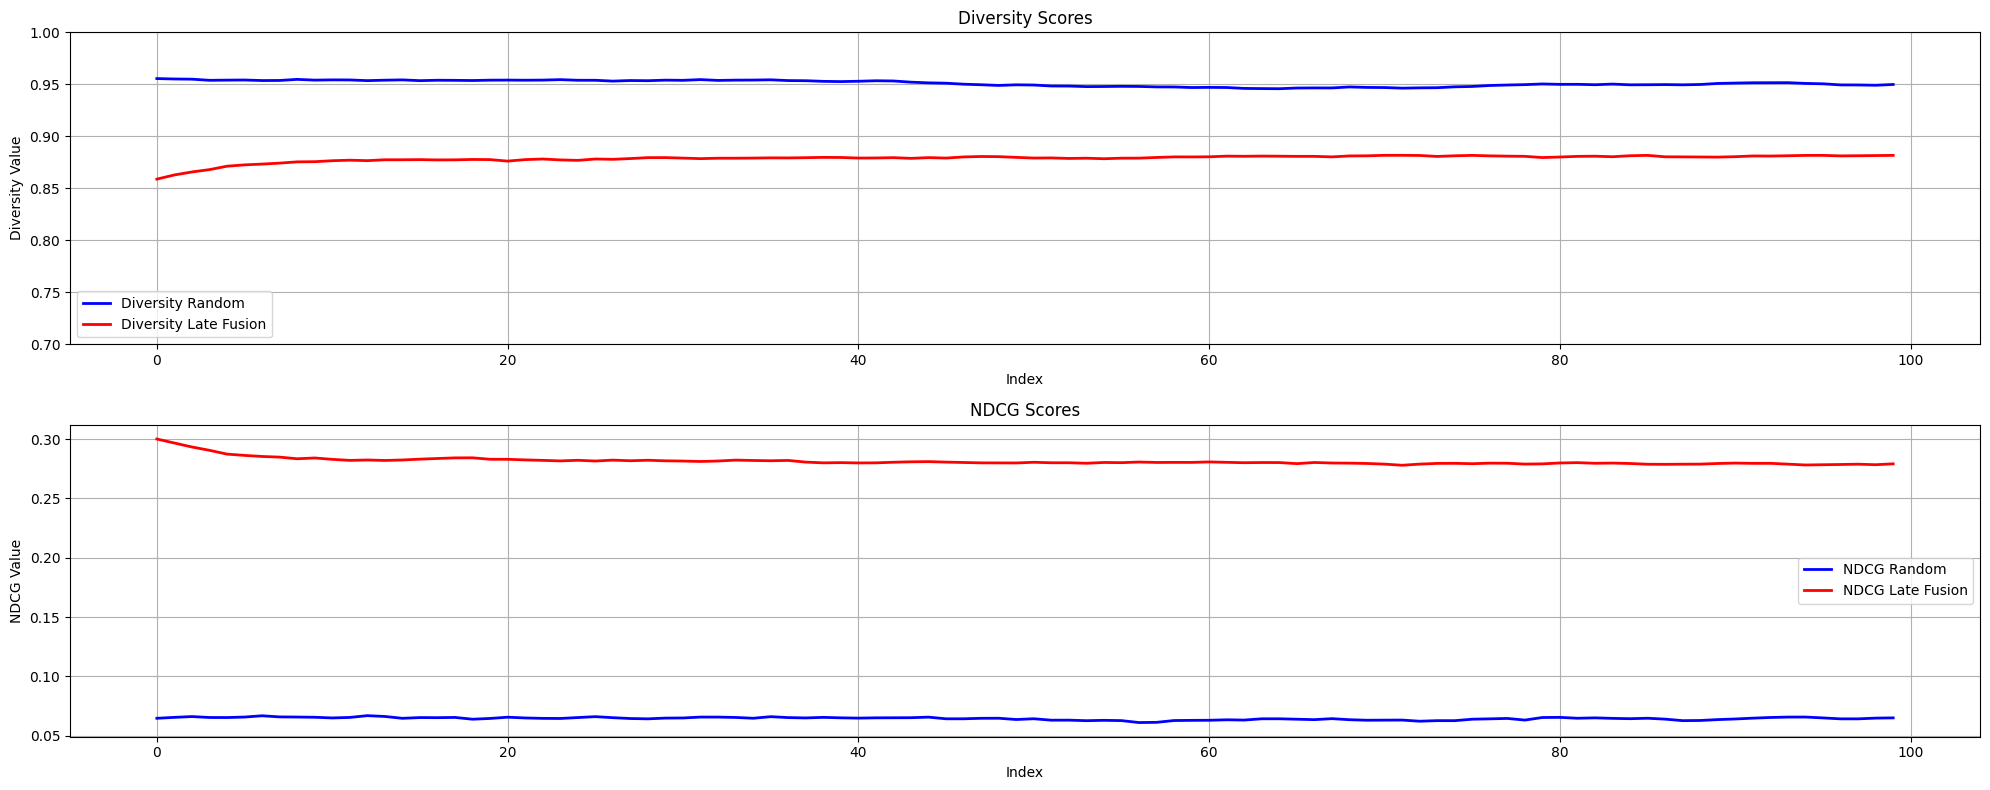

In [102]:
# Create subplots: 2 rows, 1 column

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))  # figsize adjusts the overall plot size
y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)

# Plot div values on the first subplot (ax1)
ax1.plot(range(len(divs_random_half)), divs_random_half, label='Diversity Random', color='blue', linewidth=2)
ax1.plot(range(len(divs_late_fusion_half)), divs_late_fusion_half, label='Diversity Late Fusion', color='red', linewidth=2)
ax1.set_xlabel('Index')  # Label for the x-axis
ax1.set_ylabel('Diversity Value')  # Label for the y-axis
ax1.set_title('Diversity Scores')  # Title for the plot
ax1.set_yticks(y_ticks)  # Set y-ticks using the common step size
ax1.legend()  # Show legend
ax1.grid(True)  # Show grid

# Plot ndcg values on the second subplot (ax2)
ax2.plot(range(len(ndcg_random_half)), ndcg_random_half, label='NDCG Random', color='blue', linewidth=2)
ax2.plot(range(len(ndcg_late_fusion_half)), ndcg_late_fusion_half, label='NDCG Late Fusion', color='red', linewidth=2)
ax2.set_xlabel('Index')  # Label for the x-axis
ax2.set_ylabel('NDCG Value')  # Label for the y-axis
ax2.set_title('NDCG Scores')  # Title for the plot
ax2.set_yticks(y_ticks_2)  # Set y-ticks using the common step size
ax2.legend()  # Show legend
ax2.grid(True)  # Show grid

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

[0.7470619133087222, 0.7496096667724303, 0.7512195952298328, 0.7524721538062826, 0.7544621566157603, 0.7552682640745952, 0.7556896759300421, 0.7563245036374838, 0.7570188157181905, 0.7572860659248399, 0.7577980128982078, 0.7580346567651054, 0.7577492093785051, 0.7583329395890207, 0.7584205532110633, 0.7586723475532567, 0.7585482384089508, 0.7587249655314079, 0.7590237504221756, 0.7586709186015747, 0.757501711276968, 0.7585562386708918, 0.7589421805158231, 0.7581539451322388, 0.7579165052433083, 0.7588268131322105, 0.7587468235930351, 0.7592229193180342, 0.7600196667451026, 0.7599548598255533, 0.7595237529520992, 0.7590441029499299, 0.7594477847802872, 0.759604742713003, 0.7596394657673593, 0.7597668917966032, 0.7597685999349075, 0.7596680862740511, 0.7597787095007585, 0.7597360962823773, 0.7592405891455807, 0.7593238671728549, 0.7596659246102913, 0.759204932139802, 0.7597997467785671, 0.759372392864735, 0.7601781075035396, 0.7604550530911436, 0.7603258145577114, 0.7597598167042643, 0.7

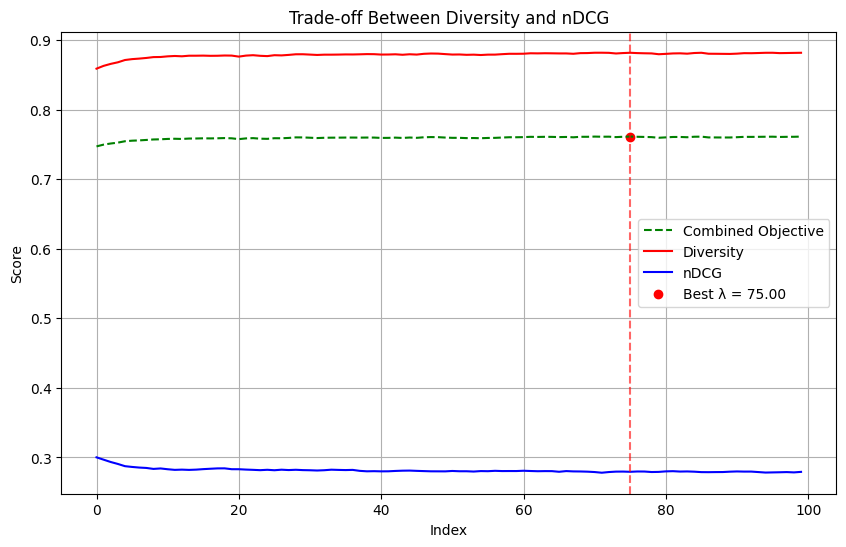

Best Lambda: 75.00
Best Combined Objective: 0.7612
Diversity at Best Lambda: 0.8816
NDCG at Best Lambda: 0.2793


In [105]:
alpha = 0.8  # Equal weight for diversity and NDCG

# Compute the combined objective
combined_objective = [
    alpha * div + (1 - alpha) * ndcg
    for div, ndcg in zip(divs_late_fusion_half, ndcg_late_fusion_half)
]

# Find the best lambda
best_index = np.argmax(combined_objective)
best_lambda = range(len(divs_late_fusion_half))[best_index]
best_objective = combined_objective[best_index]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Diversity and NDCG

# Plot combined objective
plt.plot(range(len(divs_late_fusion_half)), combined_objective, label="Combined Objective", linestyle='--', color='green')
plt.plot(range(len(divs_late_fusion_half)), divs_late_fusion_half, label="Diversity", color='red')
plt.plot(range(len(divs_late_fusion_half)), ndcg_late_fusion_half, label="nDCG", color='blue')

# Mark the best lambda
plt.scatter(best_lambda, best_objective, color='red', label=f"Best λ = {best_lambda:.2f}")
plt.axvline(best_lambda, color='red', linestyle='--', alpha=0.6)

# Labels and legend
plt.title("Trade-off Between Diversity and nDCG")
plt.xlabel("Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Distribution-based Method

Using a Distribution to Sample the re-rank data based on this, we can simulate something like a gradient descent for ItemKNNs

## Exponential Distribution


In [16]:
def normalize(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score)

# Step 3: Apply softmax to the normalized scores to create a probability distribution
def softmax_with_temperature(scores, temperature=0.1):
    # Apply temperature to the scores before softmax
    scores = scores / temperature
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores)

def select_items_unique(probabilities, topK=10):
    # Use numpy's random.choice with replace=False to ensure unique selections
    return np.random.choice(range(len(probabilities)), size=topK, replace=False, p=probabilities)

def adjust_weights(scores, power=1.0):
    # Raise similarity scores to a power to increase the weight of higher scores
    return np.power(scores, power)


In [17]:
lambda_range = np.linspace(0.01, 0.5, num=50)

divs_random_lambda =        [diversity_at_k(random_sample, tags, genres, k=topK)]
ndcg_random_lambda =        [ndcg_at_k(random_sample, ground_truth, k=topK)]
divs_late_fusion_lambda =   [diversity_at_k(late_fusion, tags, genres, k=topK)]
ndcg_late_fusion_lambda =   [ndcg_at_k(late_fusion, ground_truth, k=topK)]

for lambda_val in tqdm(lambda_range, total=len(lambda_range)):

    random_sample_new = np.zeros((len(infos), len(infos)))
    for idx, val in enumerate(random_sample):
        normalized_scores = normalize(val)
        probabilities = softmax_with_temperature(normalized_scores, temperature=lambda_val)
        selected_items = select_items_unique(probabilities, topK=topK)
        random_sample_new[idx, selected_items] = val[selected_items]
        
    
    late_fusion_new = np.zeros((len(infos), len(infos)))
    for idx, val in enumerate(late_fusion):
        normalized_scores = normalize(val)
        probabilities = softmax_with_temperature(normalized_scores, temperature=lambda_val)
        selected_items = select_items_unique(probabilities, topK=topK)
        late_fusion_new[idx, selected_items] = val[selected_items]
        

    divs_random_lambda.append(diversity_at_k(random_sample_new, tags, genres, k=topK))
    ndcg_random_lambda.append(ndcg_at_k(random_sample_new, ground_truth, k=topK))

    divs_late_fusion_lambda.append(diversity_at_k(late_fusion_new, tags, genres, k=topK))
    ndcg_late_fusion_lambda.append(ndcg_at_k(late_fusion_new, ground_truth, k=topK))

100%|██████████| 50/50 [19:54<00:00, 23.90s/it]


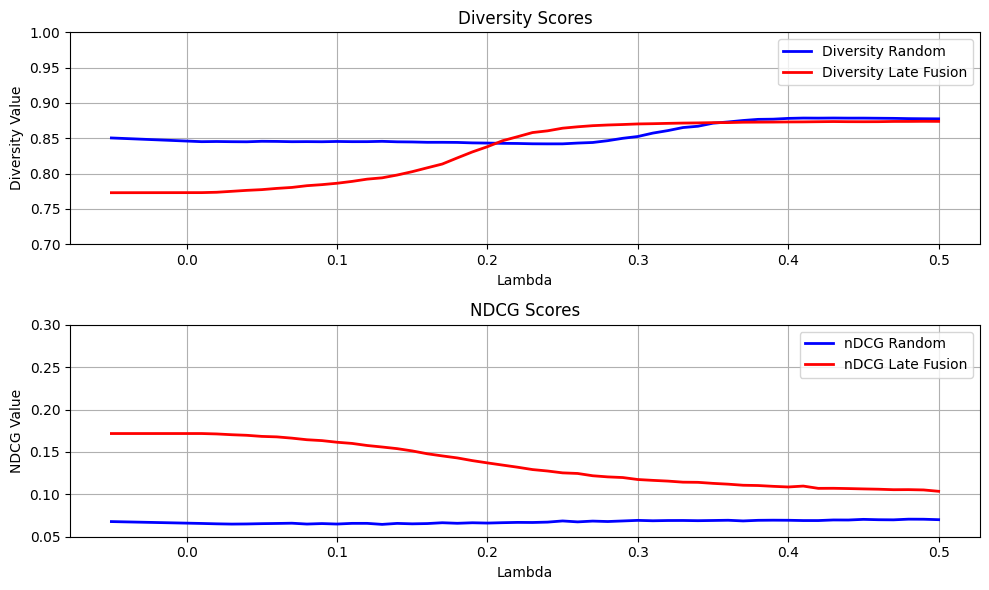

In [20]:
# Create subplots: 2 rows, 1 column

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))  # figsize adjusts the overall plot size
y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)


lambda_range = np.linspace(0.01, 0.5, num=50)
x_axis = np.zeros((len(lambda_range) + 1))
x_axis[0] = -0.05
x_axis[1:] = lambda_range

# Plot div values on the first subplot (ax1)
ax1.plot(x_axis, divs_random_lambda, label='Diversity Random', color='blue', linewidth=2)
ax1.plot(x_axis, divs_late_fusion_lambda, label='Diversity Late Fusion', color='red', linewidth=2)
ax1.set_xlabel('Lambda')  # Label for the x-axis
ax1.set_ylabel('Diversity Value')  # Label for the y-axis
ax1.set_title('Diversity Scores')  # Title for the plot
ax1.set_yticks(y_ticks)  # Set y-ticks using the common step size
ax1.legend()  # Show legend
ax1.grid(True)  # Show grid

# Plot ndcg values on the second subplot (ax2)
ax2.plot(x_axis, ndcg_random_lambda, label='nDCG Random', color='blue', linewidth=2)
ax2.plot(x_axis, ndcg_late_fusion_lambda, label='nDCG Late Fusion', color='red', linewidth=2)
ax2.set_xlabel('Lambda')  # Label for the x-axis
ax2.set_ylabel('NDCG Value')  # Label for the y-axis
ax2.set_title('NDCG Scores')  # Title for the plot
ax2.set_yticks(y_ticks_2)  # Set y-ticks using the common step size
ax2.legend()  # Show legend
ax2.grid(True)  # Show grid

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

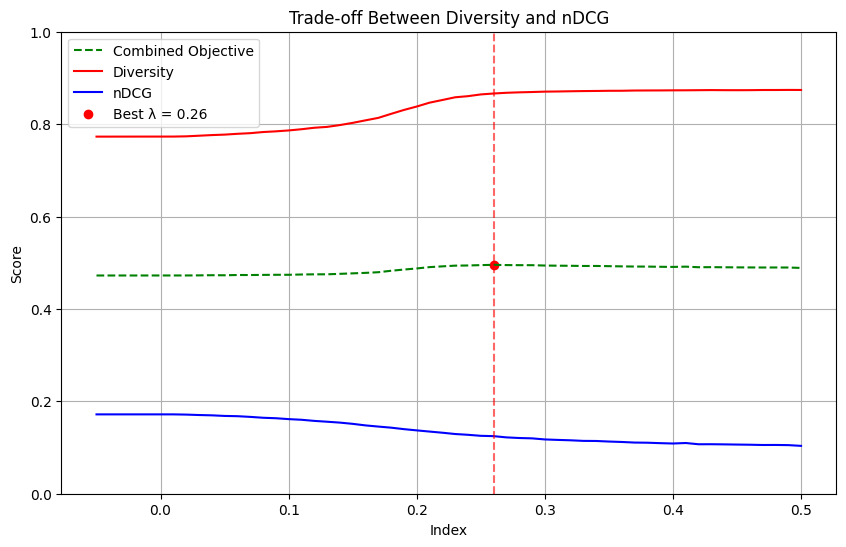

In [23]:
alpha = 0.5  # Equal weight for diversity and NDCG

# Compute the combined objective
combined_objective = [
    alpha * div + (1 - alpha) * ndcg
    for div, ndcg in zip(divs_late_fusion_lambda, ndcg_late_fusion_lambda)
]

# Find the best lambda
best_index = np.argmax(combined_objective)
best_lambda = x_axis[best_index]
best_objective = combined_objective[best_index]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Diversity and NDCG

# Plot combined objective
plt.plot(x_axis, combined_objective, label="Combined Objective", linestyle='--', color='green')
plt.plot(x_axis, divs_late_fusion_lambda, label="Diversity", color='red')
plt.plot(x_axis, ndcg_late_fusion_lambda, label="nDCG", color='blue')

# Mark the best lambda
plt.scatter(best_lambda, best_objective, color='red', label=f"Best λ = {best_lambda:.2f}")
plt.axvline(best_lambda, color='red', linestyle='--', alpha=0.6)

# Labels and legend
plt.title("Trade-off Between Diversity and nDCG")
plt.xlabel("Index")
plt.ylabel("Score")
plt.ylim((0,1))
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Gamma Distribution

In [ ]:
import itertools

divs_random_gamma = [diversity_at_k(random_sample, tags, genres, k=topK)]
ndcg_random_gamma = [ndcg_at_k(random_sample, ground_truth, k=topK)]
divs_late_fusion_gamma = [diversity_at_k(late_fusion, tags, genres, k=topK)]
ndcg_late_fusion_gamma = [ndcg_at_k(late_fusion, ground_truth, k=topK)]

power_range = np.linspace(0.1, 4, num=10)[::-1]
lambda_range = np.linspace(0.01, 1, num=10)

combinations = itertools.product(lambda_range, power_range)

for lambda_val, power_val in tqdm(combinations, total=len(lambda_range) * len(power_range)):
    random_sample_new = np.zeros((len(infos), len(infos)))
    for idx, val in enumerate(random_sample):
        normalized_scores = normalize(val)
        adjusted_scores = adjust_weights(normalized_scores, power=power_val)
        probabilities = softmax_with_temperature(adjusted_scores, temperature=lambda_val)
        selected_items = select_items_unique(probabilities, topK=topK)
        random_sample_new[idx, selected_items] = val[selected_items]
        
    
    late_fusion_new = np.zeros((len(infos), len(infos)))
    for idx, val in enumerate(late_fusion):
        normalized_scores = normalize(val)
        adjusted_scores = adjust_weights(normalized_scores, power=power_val)
        probabilities = softmax_with_temperature(adjusted_scores, temperature=lambda_val)
        selected_items = select_items_unique(probabilities, topK=topK)
        late_fusion_new[idx, selected_items] = val[selected_items]

    divs_random_gamma.append(diversity_at_k(random_sample_new, tags, genres, k=topK))
    ndcg_random_gamma.append(ndcg_at_k(random_sample_new, ground_truth, k=topK))

    divs_late_fusion_gamma.append(diversity_at_k(late_fusion_new, tags, genres, k=topK))
    ndcg_late_fusion_gamma.append(ndcg_at_k(late_fusion_new, ground_truth, k=topK))

100%|██████████| 100/100 [18:02<00:00, 10.83s/it]


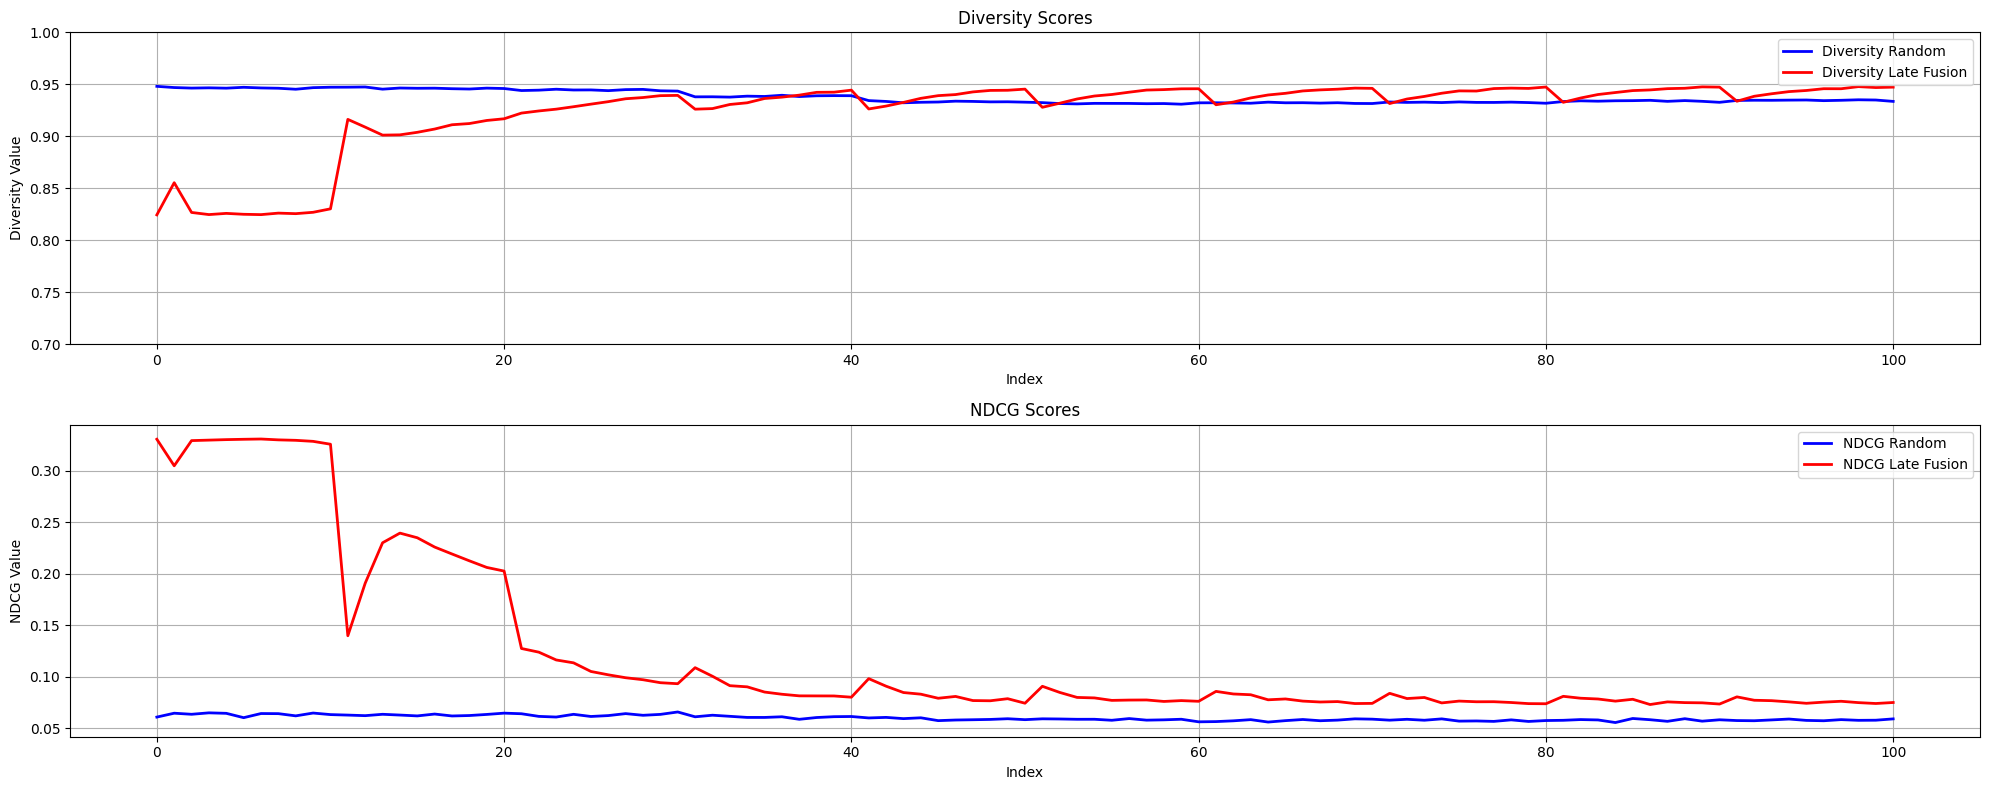

In [ ]:
# Create subplots: 2 rows, 1 column

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))  # figsize adjusts the overall plot size
y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)

# Plot div values on the first subplot (ax1)
ax1.plot(range(len(divs_random_gamma)), divs_random_gamma, label='Diversity Random', color='blue', linewidth=2)
ax1.plot(range(len(divs_late_fusion_gamma)), divs_late_fusion_gamma, label='Diversity Late Fusion', color='red', linewidth=2)
ax1.set_xlabel('Index')  # Label for the x-axis
ax1.set_ylabel('Diversity Value')  # Label for the y-axis
ax1.set_title('Diversity Scores')  # Title for the plot
ax1.set_yticks(y_ticks)  # Set y-ticks using the common step size
ax1.legend()  # Show legend
ax1.grid(True)  # Show grid

# Plot ndcg values on the second subplot (ax2)
ax2.plot(range(len(ndcg_random_gamma)), ndcg_random_gamma, label='NDCG Random', color='blue', linewidth=2)
ax2.plot(range(len(ndcg_late_fusion_gamma)), ndcg_late_fusion_gamma, label='NDCG Late Fusion', color='red', linewidth=2)
ax2.set_xlabel('Index')  # Label for the x-axis
ax2.set_ylabel('NDCG Value')  # Label for the y-axis
ax2.set_title('NDCG Scores')  # Title for the plot
ax2.set_yticks(y_ticks_2)  # Set y-ticks using the common step size
ax2.legend()  # Show legend
ax2.grid(True)  # Show grid

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

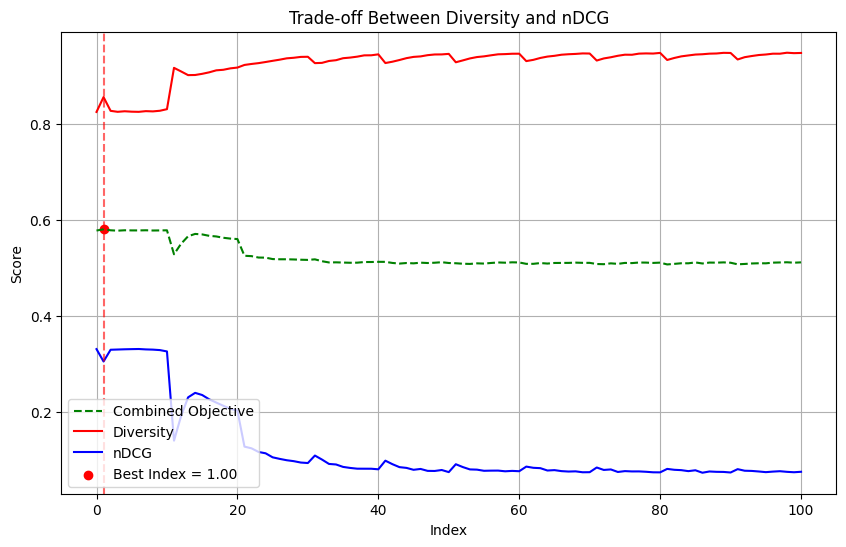

In [138]:
alpha = 0.5  # Equal weight for diversity and NDCG

# Compute the combined objective
combined_objective = [
    alpha * div + (1 - alpha) * ndcg
    for div, ndcg in zip(divs_late_fusion_gamma, ndcg_late_fusion_gamma)
]

# Find the best lambda
best_index = np.argmax(combined_objective)
best_lambda = range(len(divs_late_fusion_gamma))[best_index]
best_objective = combined_objective[best_index]


# Plot the results
plt.figure(figsize=(10, 6))

# Plot Diversity and NDCG

# Plot combined objective
plt.plot(range(len(divs_late_fusion_gamma)), combined_objective, label="Combined Objective", linestyle='--', color='green')
plt.plot(range(len(divs_late_fusion_gamma)), divs_late_fusion_gamma, label="Diversity", color='red')
plt.plot(range(len(divs_late_fusion_gamma)), ndcg_late_fusion_gamma, label="nDCG", color='blue')

# Mark the best lambda
plt.scatter(best_lambda, best_objective, color='red', label=f"Best Index = {best_lambda:.2f}")
plt.axvline(best_lambda, color='red', linestyle='--', alpha=0.6)

# Labels and legend
plt.title("Trade-off Between Diversity and nDCG")
plt.xlabel("Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Mean Marginal Relevancy 


In [25]:
print("Loading data...")
infos = pd.read_csv("dataset/id_information_mmsr.tsv", sep="\t")
inter_true = np.loadtxt("./predictions/binary_relevancy_matrix_00.csv", delimiter="\t")
tags = pd.read_csv("./dataset/id_tags_dict.tsv", sep="\t")
genres = pd.read_csv("./dataset/id_genres_mmsr.tsv", sep="\t")

topK=10
n_jobs=4
lambda_diversity_space = np.linspace(0, 1, 50)

Loading data...


In [27]:
diverse_matrix = np.zeros((lambda_diversity_space.shape[0], late_fusion.shape[0], late_fusion.shape[1]))

for idx_param, param in enumerate(lambda_diversity_space):
    
    with tqdm_joblib(desc="Processing Single Modal Vector Retrieval", total=len(infos)):
    # Parallelize the inner loop using joblib. The total parameter ensures tqdm works correctly
        results = Parallel(n_jobs=n_jobs)(delayed(get_diverse_recommendations_batch)(song, late_fusion, k=topK, lambda_diversity=param)
                                        for song in late_fusion)

        # Update the diverse_matrix with the results
        for idx, res in enumerate(results):
            diverse_matrix[idx_param, idx, res] = late_fusion[idx, res]

divs = [diversity_at_k(late_fusion, tags, genres, k=10)]
ndcgs = [ndcg_at_k(late_fusion, inter_true, k=10)]
for x in tqdm(range(lambda_diversity_space.shape[0]), total=lambda_diversity_space.shape[0]):
    divs.append(diversity_at_k(diverse_matrix[x], tags, genres, k=10))
    ndcgs.append(ndcg_at_k(diverse_matrix[x], inter_true, k=10))

100%|██████████| 50/50 [02:51<00:00,  3.42s/it]


In [30]:
divs_random = []
ndcg_random = []

diverse_matrix_random = np.zeros((lambda_diversity_space.shape[0], late_fusion.shape[0], late_fusion.shape[1]))

for idx_param, param in enumerate(lambda_diversity_space):
    
    with tqdm_joblib(desc="Processing Single Modal Vector Retrieval", total=len(infos)):
    # Parallelize the inner loop using joblib. The total parameter ensures tqdm works correctly
        results = Parallel(n_jobs=n_jobs)(delayed(get_diverse_recommendations_batch)(song, random_sample, k=topK, lambda_diversity=param)
                                        for song in random_sample)

        # Update the diverse_matrix with the results
        for idx, res in enumerate(results):
            diverse_matrix_random[idx_param, idx, res] = random_sample[idx, res]


divs_random = [diversity_at_k(random_sample, tags, genres, k=10)]
ndcgs_random = [ndcg_at_k(random_sample, inter_true, k=10)]
for x in tqdm(range(lambda_diversity_space.shape[0]), total=lambda_diversity_space.shape[0]):
    divs_random.append(diversity_at_k(diverse_matrix_random[x], tags, genres, k=10))
    ndcgs_random.append(ndcg_at_k(diverse_matrix_random[x], inter_true, k=10))

100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


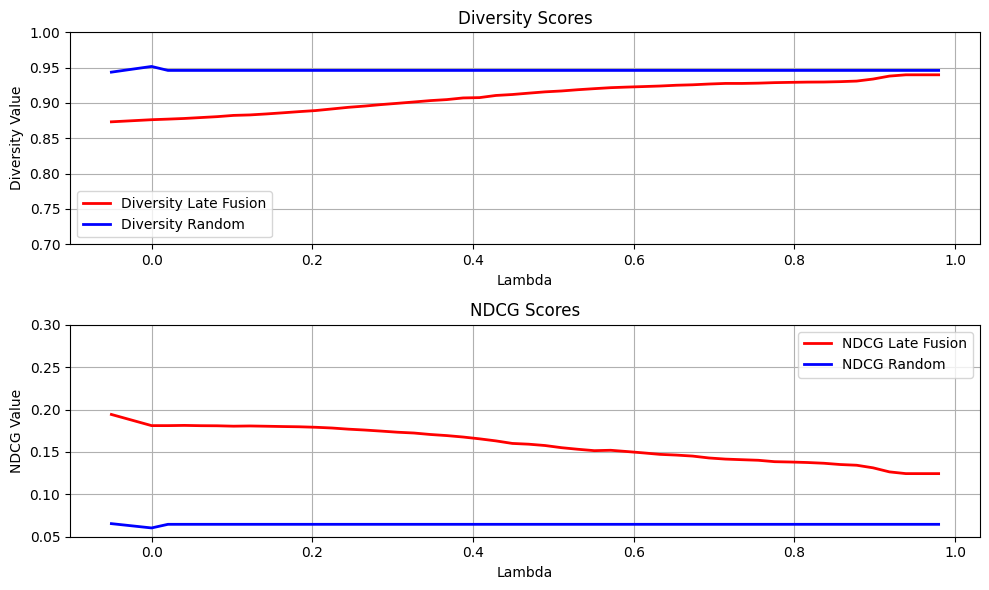

In [39]:
# Create subplots: 2 rows, 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))  # figsize adjusts the overall plot size
y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)


x_axis = np.zeros((49 + 1))
x_axis[0] = -0.05
x_axis[1:] = lambda_diversity_space[:49]

y_ticks = np.arange(0.7, 1., 0.05)
y_ticks_2 = np.arange(0.05, 0.35, 0.05)

# Plot div values on the first subplot (ax1)
ax1.plot(x_axis, divs[:50], label='Diversity Late Fusion', color='red', linewidth=2)
ax1.plot(x_axis, divs_random[:50], label='Diversity Random', color='blue', linewidth=2)
ax1.set_xlabel('Lambda')  # Label for the x-axis
ax1.set_ylabel('Diversity Value')  # Label for the y-axis
ax1.set_title('Diversity Scores')  # Title for the plot
ax1.set_yticks(y_ticks)
ax1.legend()  # Show legend
ax1.grid(True)  # Show grid

# Plot ndcg values on the second subplot (ax2)
ax2.plot(x_axis, ndcgs[:50], label='NDCG Late Fusion', color='red', linewidth=2)
ax2.plot(x_axis, ndcgs_random[:50], label='NDCG Random', color='blue', linewidth=2)
ax2.set_xlabel('Lambda')  # Label for the x-axis
ax2.set_ylabel('NDCG Value')  # Label for the y-axis
ax2.set_title('NDCG Scores')  # Title for the plot
ax2.legend()  # Show legend
ax2.set_yticks(y_ticks_2)
ax2.grid(True)  # Show grid

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

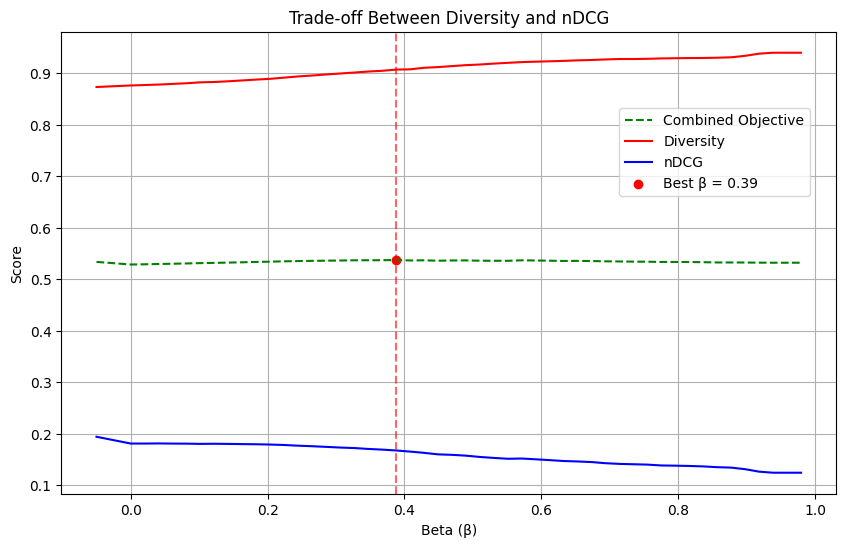

In [47]:
alpha = 0.5  # Equal weight for diversity and NDCG

# Compute the combined objective
combined_objective = [
    alpha * div + (1 - alpha) * ndcg
    for div, ndcg in zip(divs[:50], ndcgs[:50])
]

# Find the best lambda
best_index = np.argmax(combined_objective)
best_lambda = x_axis[best_index]
best_objective = combined_objective[best_index]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Diversity and NDCG

# Plot combined objective
plt.plot(x_axis, combined_objective, label="Combined Objective", linestyle='--', color='green')
plt.plot(x_axis, divs[:50], label="Diversity", color='red')
plt.plot(x_axis, ndcgs[:50], label="nDCG", color='blue')

# Mark the best lambda
plt.scatter(best_lambda, best_objective, color='red', label=f"Best β = {best_lambda:.2f}")
plt.axvline(best_lambda, color='red', linestyle='--', alpha=0.6)

# Labels and legend
plt.title("Trade-off Between Diversity and nDCG")
plt.xlabel("Beta (β)")
plt.ylabel("Score")
plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.85))
plt.grid(True)

# Show plot
plt.show()